<a href="https://colab.research.google.com/github/thaivo02/Stock-prediction/blob/main/Sentiment_analysis_to_predict_stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
!pip install nltk
!pip install underthesea
!pip install transformers torch
!pip install SentencePiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 39.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylin

In [ ]:
import nltk
import math
import string
import re
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import underthesea
from underthesea import word_tokenize
from underthesea import text_normalize
from datetime import datetime
import timeit

In [ ]:
import torch
from transformers import RobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Prepare data

In [ ]:
company_list = ['API', 'AGG', 'BID', 'FPT', 'VCB', 'ACV', 'OIL', 'ABB', 'ABC']

## Call API to get data

In [ ]:
headers={"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36 OPR/109.0.0.0"}

In [ ]:
company_news = {}

In [ ]:
for company in company_list:
    url = f"https://s.cafef.vn/tin-doanh-nghiep/{company}/event.chn"
    response = requests.get(url, headers = headers)
    if response.status_code == 200:
      company_news[company] = {}
      soup = BeautifulSoup(response.content, "html.parser")
      titles = soup.find_all("a", class_="docnhanhTitle")
      titles = [title.text.strip().split(": ")[-1] for title in titles]
      timeline = soup.find_all("span", class_="timeTitle")
      timeline = [time.text.strip().split(' ')[0] for time in timeline]
      company_news[company]['news'] = titles
      company_news[company]['timeline'] = timeline
      print(f"Fetched data for {company}")
    else:
      print(f"Failed to fetch data for {company}")

Fetched data for API
Fetched data for AGG
Fetched data for BID
Fetched data for FPT
Fetched data for VCB
Fetched data for ACV
Fetched data for OIL
Fetched data for ABB
Fetched data for ABC


In [ ]:
for company in company_list:
    company_date = list(company_news[company]['timeline'])
    company_news[company]['price'] = []
    startDate = company_date[-1]
    startDate = datetime.strptime(startDate, "%d/%m/%Y")
    startDate = startDate.strftime("%m/%d/%Y")
    endDate = company_date[0]
    endDate = datetime.strptime(endDate, "%d/%m/%Y")
    endDate = endDate.strftime("%m/%d/%Y")
    finished = False
    index = 1
    while not finished:
      url = f"https://s.cafef.vn/Ajax/PageNew/DataHistory/PriceHistory.ashx?Symbol={company}&StartDate={startDate}&EndDate={endDate}&PageIndex={index}"
      response = requests.get(url)
      if response.status_code == 200:
        data = response.json()
        if 'Data' in data:
            data = data['Data']['Data']
            for date in company_date:
                for item in data:
                    if item['Ngay'] == date:
                        company_news[company]['price'].append(float(item['GiaDongCua']))
      else:
        print(f"Failed to fetch price data for {company}")
      if len(data) == 0:
        finished = True
      elif datetime.strptime(data[-1]['Ngay'], "%d/%m/%Y") <= datetime.strptime(company_date[-1], "%d/%m/%Y"):
        finished = True
      else:
        index += 1
    price_len = len(company_news[company]['price'])
    date_len = len(company_date)
    if price_len < date_len:
        last_price = company_news[company]['price'][-1] if price_len > 0 else 0
        company_news[company]['price'].extend([last_price] * (date_len - price_len))

## Preprocess data

## Use model VADER from NLTK

### Load model

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
start = timeit.default_timer()

for company, item in company_news.items():
    company_news[company]['sentiment'] = []
    for title in item['news']:
      sentiment = analyzer.polarity_scores(title)
      company_news[company]['sentiment'].append(sentiment['compound'])
      print(f"{company}: {title} - {sentiment}")

stop = timeit.default_timer()

vader_time_execution = stop - start

API: Cổ phiếu “họ” Apec đồng loạt quay xe chóng vánh, nhà đầu tư lỡ đua lệnh giá trần tạm lỗ gần 20% - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: Thay đổi giấy ĐKKD do đổi người đại diện pháp luật - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: Giải trình giá cổ phiếu tăng trần 5 phiên liên tiếp - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: Cổ phiếu 'họ Apec' tăng trần phiên thứ ba sau sự xuất hiện bất ngờ của ông Nguyễn Đỗ Lăng - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: Nghị quyết HĐQT thống nhất ông Nguyễn Đức Quân làm Chủ tịch HĐQT - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: Con gái sinh năm 2001 của ông Nguyễn Đỗ Lăng trở thành lãnh đạo cấp cao tại APEC Investment (API ) - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: Ông Nguyễn Đức Quân làm Chủ tịch HĐQT, bà Nguyễn Thị Ngọc Hà làm Trưởng BKS từ 13.5.2024 - {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
API: Nghị quyết ĐHCĐ thường niê

In [ ]:
for company, item in company_news.items():
  print(f"{company}: {item}")
  print(f"Number of news: {len(item['news'])}")
  print(f"Number of timeline: {len(item['timeline'])}")
  print(f"Number of price: {len(item['price'])}")

API: {'news': ['Cổ phiếu “họ” Apec đồng loạt quay xe chóng vánh, nhà đầu tư lỡ đua lệnh giá trần tạm lỗ gần 20%', 'Thay đổi giấy ĐKKD do đổi người đại diện pháp luật', 'Giải trình giá cổ phiếu tăng trần 5 phiên liên tiếp', "Cổ phiếu 'họ Apec' tăng trần phiên thứ ba sau sự xuất hiện bất ngờ của ông Nguyễn Đỗ Lăng", 'Nghị quyết HĐQT thống nhất ông Nguyễn Đức Quân làm Chủ tịch HĐQT', 'Con gái sinh năm 2001 của ông Nguyễn Đỗ Lăng trở thành lãnh đạo cấp cao tại APEC Investment (API )', 'Ông Nguyễn Đức Quân làm Chủ tịch HĐQT, bà Nguyễn Thị Ngọc Hà làm Trưởng BKS từ 13.5.2024', 'Nghị quyết ĐHCĐ thường niên năm 2024', 'Biện pháp, lộ trình khắc phục chứng khoán bị cảnh báo', 'Công ty "họ APEC" API kinh doanh ra sao sau vụ thao túng chứng khoán đình đám khiến chủ tịch vướng lao lý?', 'Báo cáo thường niên 2023', '10.5.2024, tổ chức ĐHCĐ thường niên năm 2024', 'Bổ sung lý do cổ phiếu không được phép giao dịch ký quỹ', 'Cổ phiếu bị cảnh báo từ 9.4.2024', 'Giải trình liên quan đến BCTC năm 2023', 'Đ

### Plot sentiment score

In [ ]:
vader_sentiment_scores = []

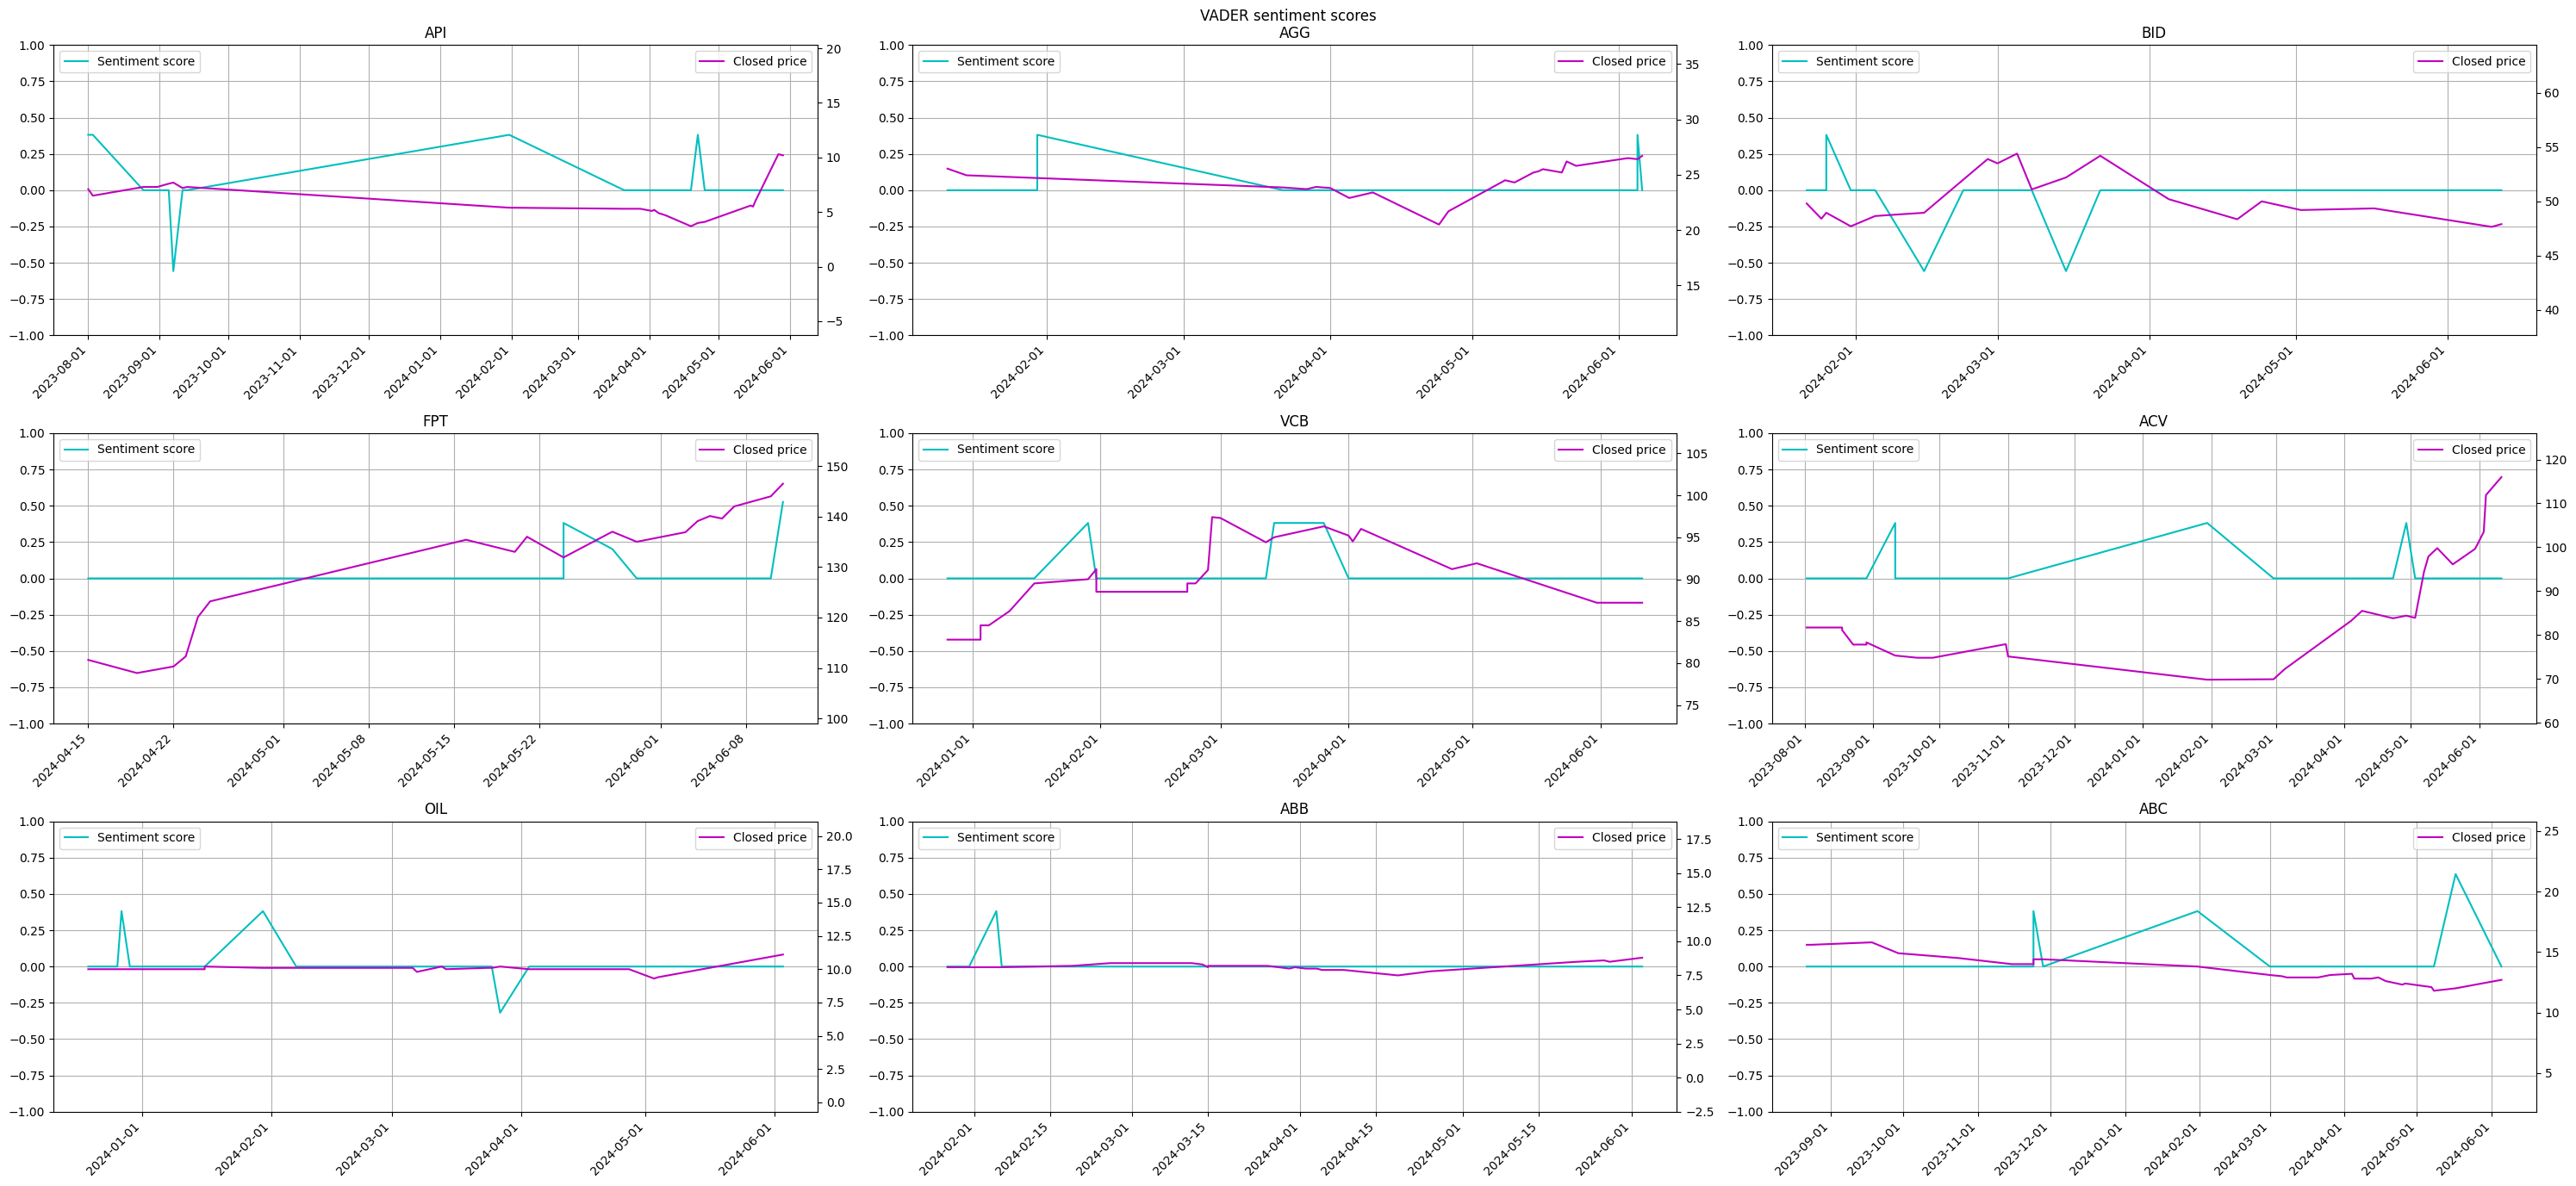

In [ ]:
fig = plt.figure(figsize=(30, 14))

for company, item in company_news.items():
    date = item['timeline']
    price = item['price']
    sentiment_scores = item['sentiment']
    plot_index = company_list.index(company) + 1
    plot_col = 3
    plot_row = (len(company_list) + plot_col - 1) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_title(company)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, sentiment_scores, color='c', label='Sentiment score')
    ax.legend(loc='upper left')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axt = ax.twinx()
    axt.plot(dates, price, color='m', label='Closed price')
    axt.legend(loc='upper right')
    axt.set_ylim(min(price) - 10, max(price) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    vader_sentiment_scores.append(sentiment_scores)

fig.suptitle('VADER sentiment scores')
plt.legend()
plt.tight_layout()
plt.savefig('vader_sentiment_scores.png')
plt.show()

### Plot volatility

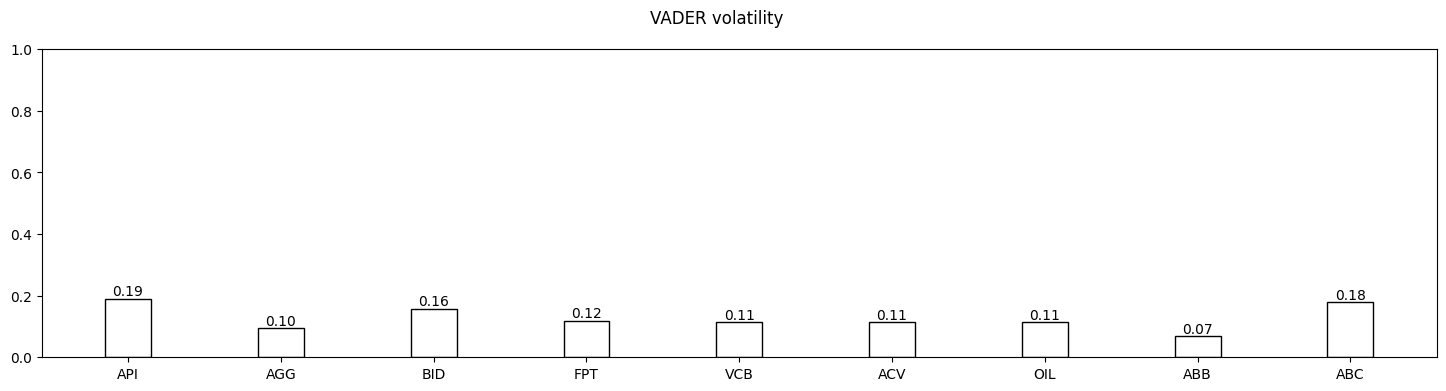

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
volatility_plot = {}

for company, item in company_news.items():
    sentiment_scores = item['sentiment']
    volatility_plot[company] = np.std(sentiment_scores)

for company, volatility in volatility_plot.items():
    plt.text(company_list.index(company), volatility, f"{volatility:.2f}", ha='center', va='bottom')

ax.bar(company_list, volatility_plot.values(), 0.3, color='w', edgecolor='k')
ax.set_ylim(0, 1)

fig.suptitle('VADER volatility')
plt.savefig('vader_volatility.png')
plt.show()

## Use PhoBERT pretrained model from Wonrax

### Tokenize Vietnamese

In [ ]:
company_tokenized = {}
for company, item in company_news.items():
  company_tokenized[company] = []
  for title in item['news']:
    # title = re.sub(r'[^\w\s]', '', title)
    underthesea_tokens = underthesea.word_tokenize(title, format="text")
    company_tokenized[company].append(underthesea_tokens)

### Load model

In [ ]:
wonrax = RobertaForSequenceClassification.from_pretrained("wonrax/phobert-base-vietnamese-sentiment")

wonrax_tokenizer = AutoTokenizer.from_pretrained("wonrax/phobert-base-vietnamese-sentiment", use_fast=False)

In [ ]:
start = timeit.default_timer()

sentiments = {}

for company, news in company_tokenized.items():
    company_news[company]['sentiment'] = []
    for title in news:
        input_ids = torch.tensor([wonrax_tokenizer.encode(title)])
        with torch.no_grad():
            out = wonrax(input_ids)
            sentiments['neg'] = round(out.logits.softmax(dim=-1).tolist()[-1][0], 3)
            sentiments['pos'] = round(out.logits.softmax(dim=-1).tolist()[-1][1], 3)
            sentiments['neu'] = round(out.logits.softmax(dim=-1).tolist()[-1][2], 3)
            sentiments['compound'] = round(sentiments['pos'] - sentiments['neg'], 4)
            company_news[company]['sentiment'].append(sentiments['compound'])
            print(f"{company}: {title} - {sentiments}")

stop = timeit.default_timer()

phobert_time_execution = stop - start

API: Cổ_phiếu “ họ ” Apec đồng_loạt quay xe chóng vánh , nhà_đầu_tư lỡ_đua lệnh giá_trần tạm lỗ gần 20 % - {'neg': 0.141, 'pos': 0.073, 'neu': 0.786, 'compound': -0.068}
API: Thay_đổi giấy ĐKKD do đổi người đại_diện pháp_luật - {'neg': 0.486, 'pos': 0.047, 'neu': 0.467, 'compound': -0.439}
API: Giải_trình giá cổ_phiếu tăng trần 5 phiên liên_tiếp - {'neg': 0.021, 'pos': 0.554, 'neu': 0.426, 'compound': 0.533}
API: Cổ_phiếu ' họ Apec ' tăng trần_phiên thứ ba sau sự xuất_hiện bất_ngờ của ông Nguyễn_Đỗ_Lăng - {'neg': 0.011, 'pos': 0.681, 'neu': 0.309, 'compound': 0.67}
API: Nghị_quyết HĐQT thống_nhất ông Nguyễn_Đức_Quân làm Chủ_tịch HĐQT - {'neg': 0.022, 'pos': 0.241, 'neu': 0.738, 'compound': 0.219}
API: Con gái sinh năm 2001 của ông Nguyễn_Đỗ_Lăng trở_thành lãnh_đạo cấp cao tại APEC_Investment ( API ) - {'neg': 0.032, 'pos': 0.389, 'neu': 0.579, 'compound': 0.357}
API: Ông Nguyễn_Đức_Quân làm Chủ_tịch HĐQT , bà Nguyễn_Thị_Ngọc_Hà làm Trưởng BKS từ 13.5.2024 - {'neg': 0.028, 'pos': 0.246,

In [ ]:
for company, item in company_news.items():
  print(f"{company}: {item}")
  print(f"Number of news: {len(item['news'])}")
  print(f"Number of timeline: {len(item['timeline'])}")
  print(f"Number of price: {len(item['price'])}")

API: {'news': ['Cổ phiếu “họ” Apec đồng loạt quay xe chóng vánh, nhà đầu tư lỡ đua lệnh giá trần tạm lỗ gần 20%', 'Thay đổi giấy ĐKKD do đổi người đại diện pháp luật', 'Giải trình giá cổ phiếu tăng trần 5 phiên liên tiếp', "Cổ phiếu 'họ Apec' tăng trần phiên thứ ba sau sự xuất hiện bất ngờ của ông Nguyễn Đỗ Lăng", 'Nghị quyết HĐQT thống nhất ông Nguyễn Đức Quân làm Chủ tịch HĐQT', 'Con gái sinh năm 2001 của ông Nguyễn Đỗ Lăng trở thành lãnh đạo cấp cao tại APEC Investment (API )', 'Ông Nguyễn Đức Quân làm Chủ tịch HĐQT, bà Nguyễn Thị Ngọc Hà làm Trưởng BKS từ 13.5.2024', 'Nghị quyết ĐHCĐ thường niên năm 2024', 'Biện pháp, lộ trình khắc phục chứng khoán bị cảnh báo', 'Công ty "họ APEC" API kinh doanh ra sao sau vụ thao túng chứng khoán đình đám khiến chủ tịch vướng lao lý?', 'Báo cáo thường niên 2023', '10.5.2024, tổ chức ĐHCĐ thường niên năm 2024', 'Bổ sung lý do cổ phiếu không được phép giao dịch ký quỹ', 'Cổ phiếu bị cảnh báo từ 9.4.2024', 'Giải trình liên quan đến BCTC năm 2023', 'Đ

### Plot sentiment score

In [ ]:
phobert_sentiment_scores = []

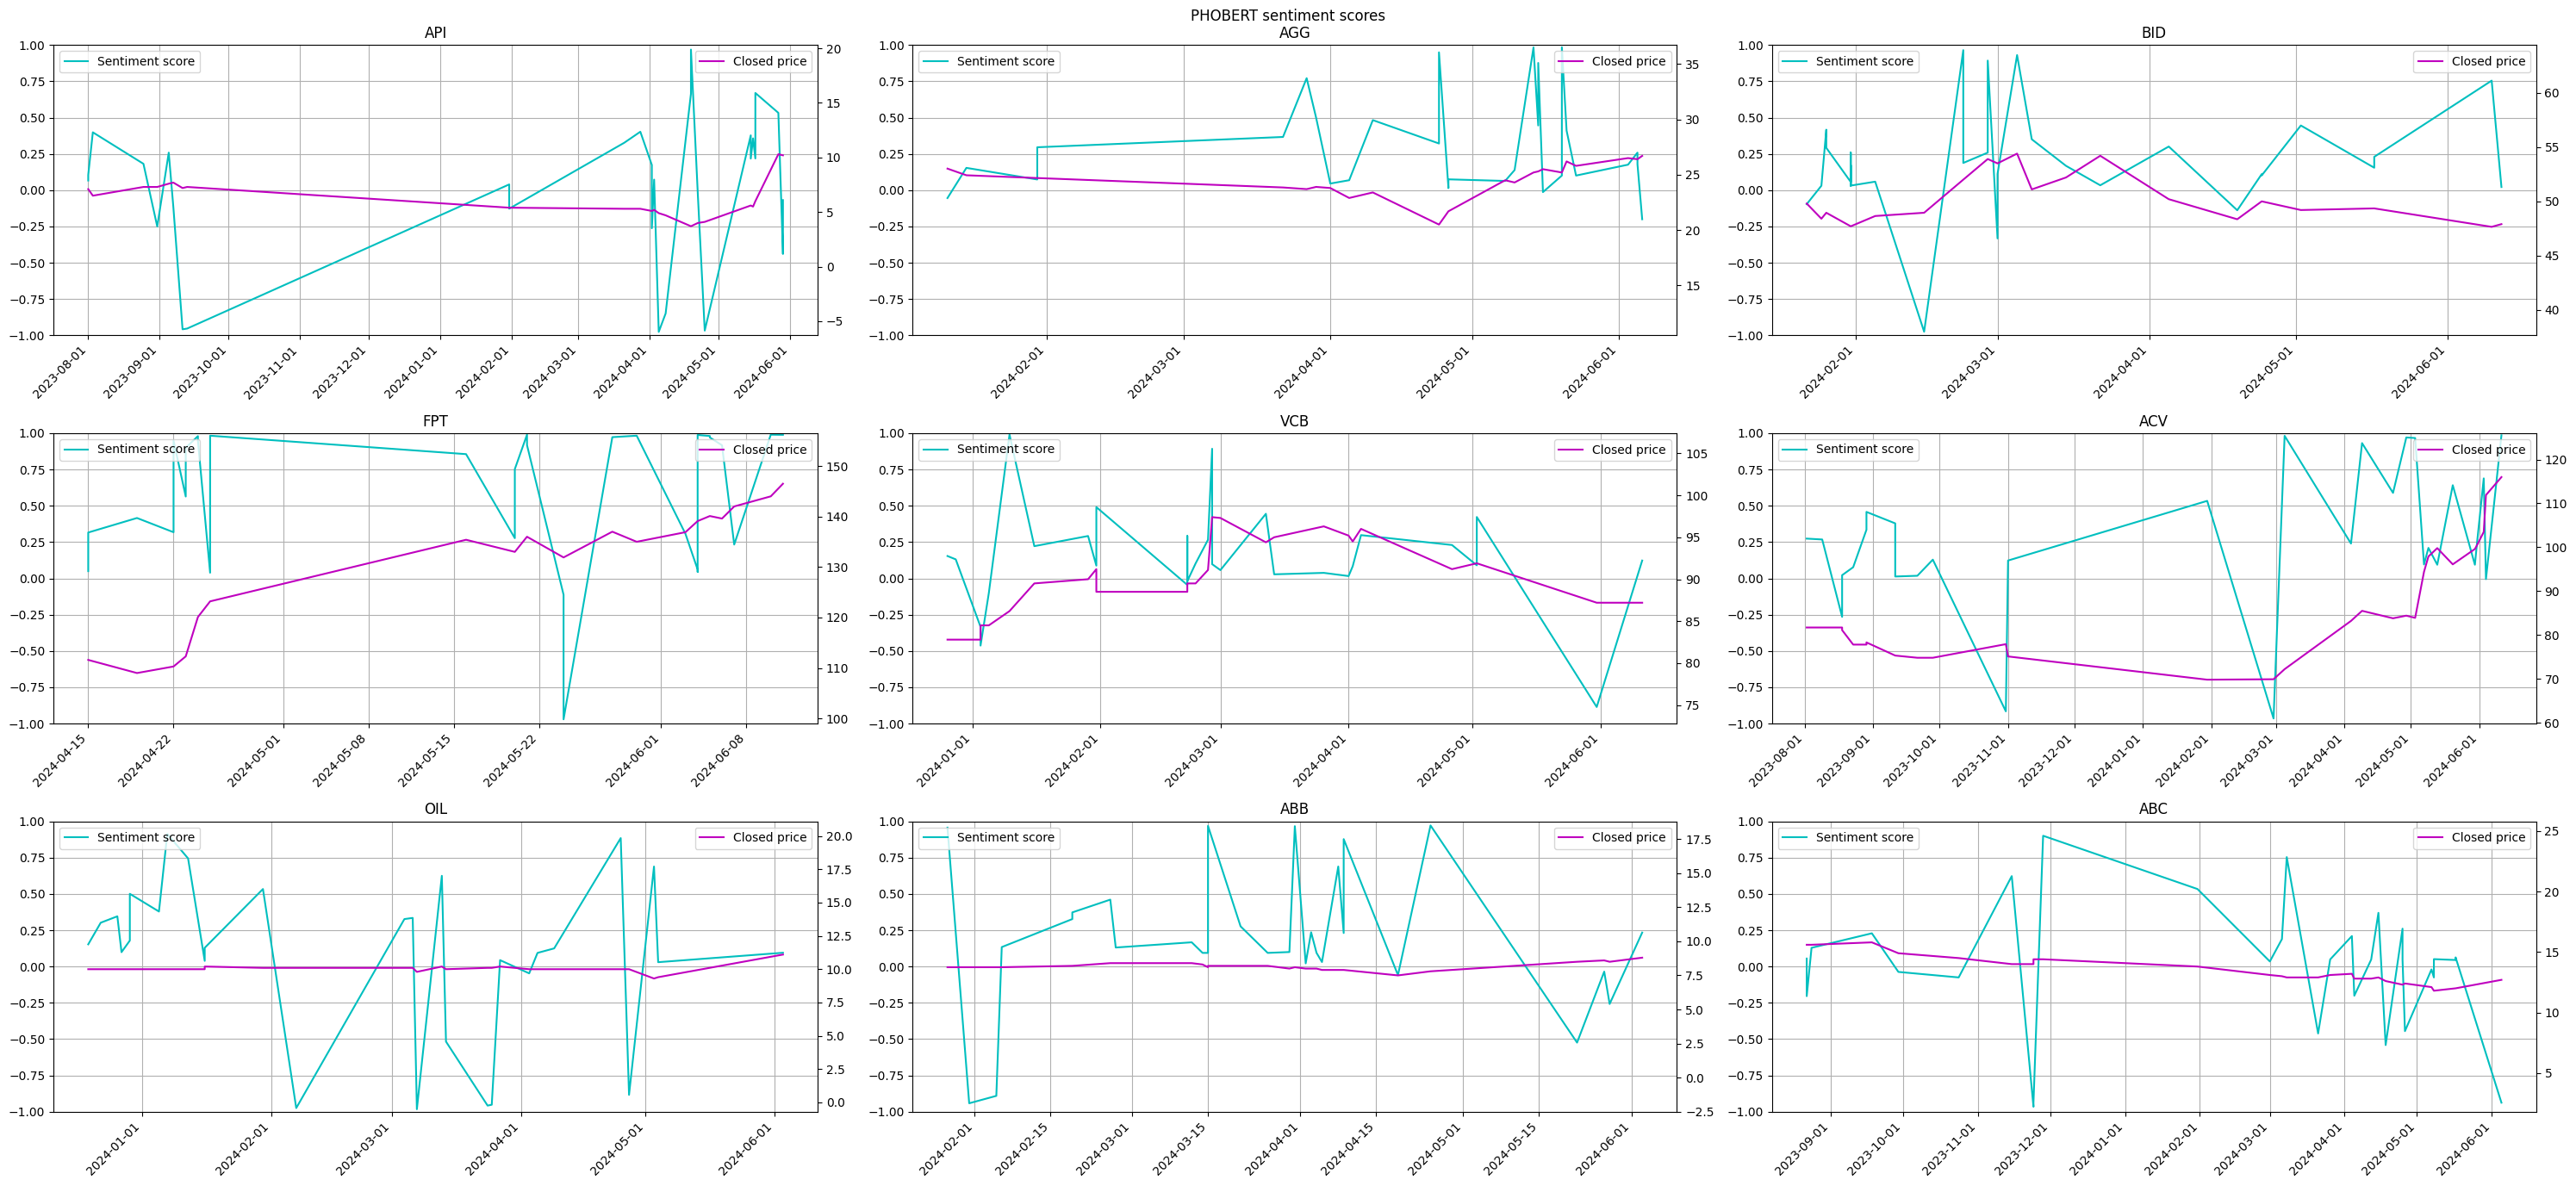

In [ ]:
fig = plt.figure(figsize=(30, 14))

for company, item in company_news.items():
    date = item['timeline']
    price = item['price']
    sentiment_scores = item['sentiment']
    plot_index = company_list.index(company) + 1
    plot_col = 3
    plot_row = (len(company_list) + plot_col - 1) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_title(company)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, sentiment_scores, color='c', label='Sentiment score')
    ax.legend(loc='upper left')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axt = ax.twinx()
    axt.plot(dates, price, color='m', label='Closed price')
    axt.legend(loc='upper right')
    axt.set_ylim(min(price) - 10, max(price) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    phobert_sentiment_scores.append(sentiment_scores)

fig.suptitle('PHOBERT sentiment scores')
plt.legend()
plt.tight_layout()
plt.savefig('phobert_sentiment_scores.png')
plt.show()

### Plot volatility

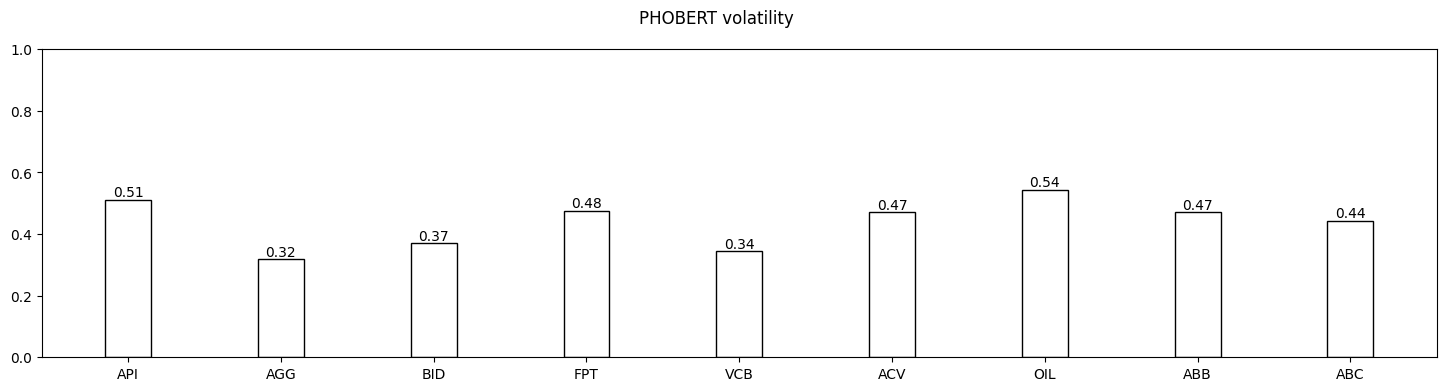

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
volatility_plot = {}

for company, item in company_news.items():
    sentiment_scores = item['sentiment']
    volatility_plot[company] = np.std(sentiment_scores)

for company, volatility in volatility_plot.items():
    plt.text(company_list.index(company), volatility, f"{volatility:.2f}", ha='center', va='bottom')

ax.bar(company_list, volatility_plot.values(), 0.3, color='w', edgecolor='k')
ax.set_ylim(0, 1)

fig.suptitle('PHOBERT volatility')
plt.savefig('phobert_volatility.png')
plt.show()

## Use ViSoBERT

### Load model

In [ ]:
uit = AutoModelForSequenceClassification.from_pretrained('uitnlp/visobert')
uit_tokenizer = AutoTokenizer.from_pretrained('uitnlp/visobert')

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
start = timeit.default_timer()

sentiments = {}

for company, news in company_tokenized.items():
    company_news[company]['sentiment'] = []
    for title in news:
        encoding = uit_tokenizer(title, return_tensors='pt')
        with torch.no_grad():
            output = uit(**encoding)
            sentiments['pos'] = round(output.logits.softmax(dim=-1).tolist()[-1][0], 3)
            sentiments['neg'] = round(output.logits.softmax(dim=-1).tolist()[-1][1], 3)
            sentiments['compound'] = round(sentiments['pos'] - sentiments['neg'], 4)
            company_news[company]['sentiment'].append(sentiments['compound'])
            print(f"{company}: {title} - {sentiments}")

stop = timeit.default_timer()

visobert_time_execution = stop - start

API: Cổ_phiếu “ họ ” Apec đồng_loạt quay xe chóng vánh , nhà_đầu_tư lỡ_đua lệnh giá_trần tạm lỗ gần 20 % - {'pos': 0.542, 'neg': 0.458, 'compound': 0.084}
API: Thay_đổi giấy ĐKKD do đổi người đại_diện pháp_luật - {'pos': 0.5, 'neg': 0.5, 'compound': 0.0}
API: Giải_trình giá cổ_phiếu tăng trần 5 phiên liên_tiếp - {'pos': 0.589, 'neg': 0.411, 'compound': 0.178}
API: Cổ_phiếu ' họ Apec ' tăng trần_phiên thứ ba sau sự xuất_hiện bất_ngờ của ông Nguyễn_Đỗ_Lăng - {'pos': 0.573, 'neg': 0.427, 'compound': 0.146}
API: Nghị_quyết HĐQT thống_nhất ông Nguyễn_Đức_Quân làm Chủ_tịch HĐQT - {'pos': 0.557, 'neg': 0.443, 'compound': 0.114}
API: Con gái sinh năm 2001 của ông Nguyễn_Đỗ_Lăng trở_thành lãnh_đạo cấp cao tại APEC_Investment ( API ) - {'pos': 0.6, 'neg': 0.4, 'compound': 0.2}
API: Ông Nguyễn_Đức_Quân làm Chủ_tịch HĐQT , bà Nguyễn_Thị_Ngọc_Hà làm Trưởng BKS từ 13.5.2024 - {'pos': 0.547, 'neg': 0.453, 'compound': 0.094}
API: Nghị_quyết ĐHCĐ thường_niên năm 2024 - {'pos': 0.594, 'neg': 0.406, 'com

### Plot sentiment score

In [ ]:
visobert_sentiment_scores = []

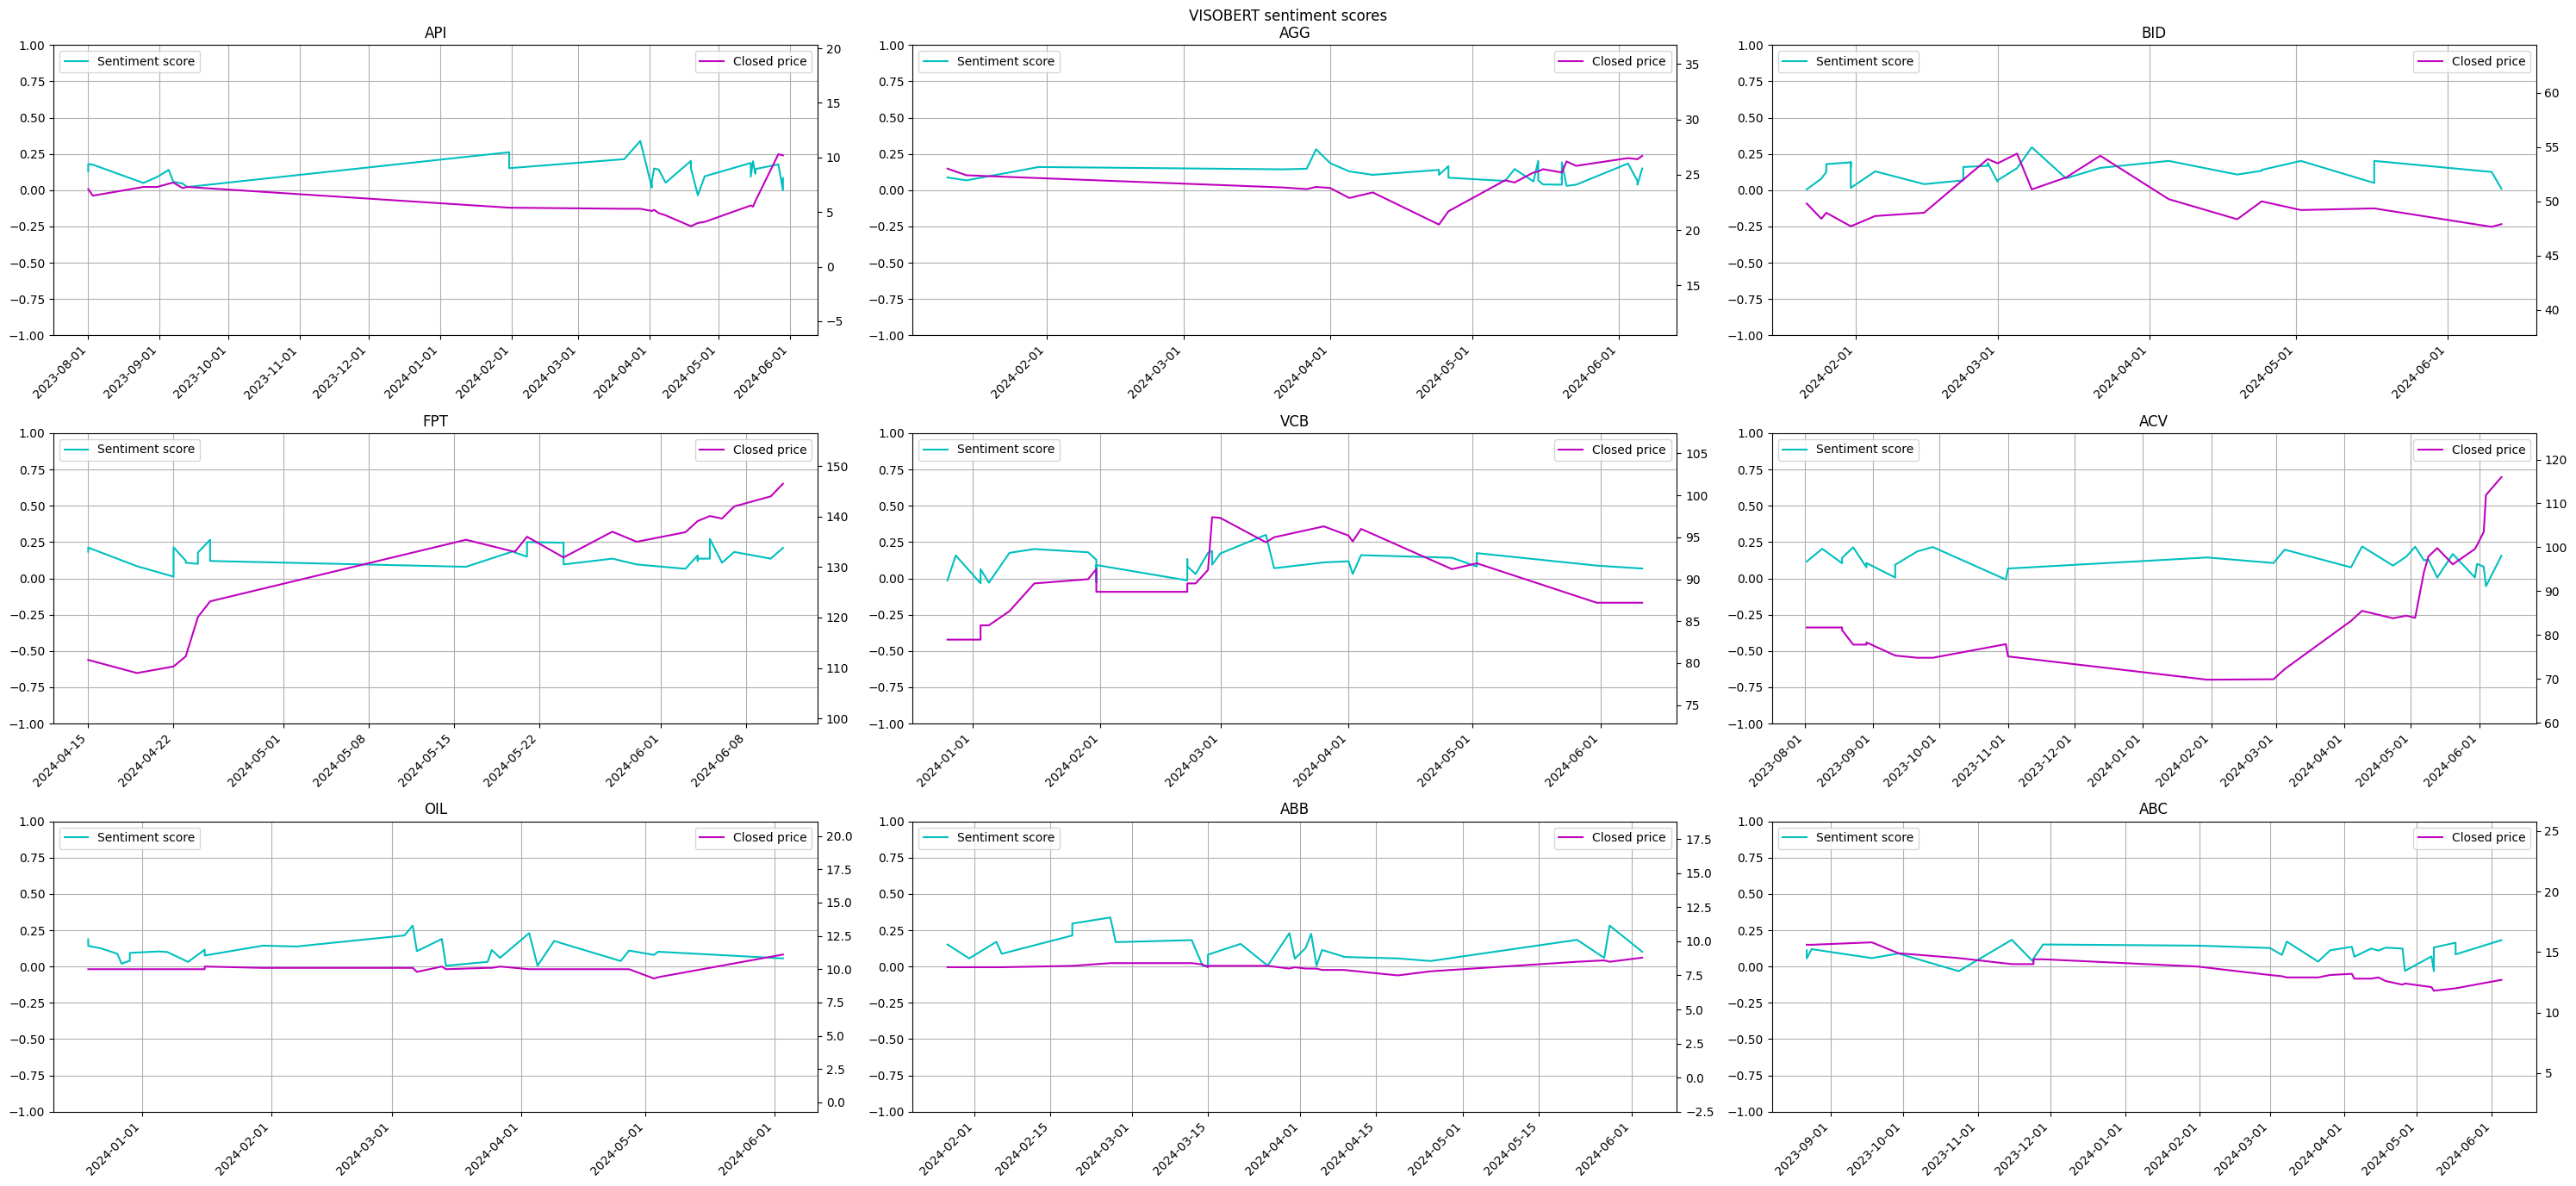

In [ ]:
fig = plt.figure(figsize=(30, 14))

for company, item in company_news.items():
    date = item['timeline']
    price = item['price']
    sentiment_scores = item['sentiment']
    plot_index = company_list.index(company) + 1
    plot_col = 3
    plot_row = (len(company_list) + plot_col - 1) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_title(company)
    ax.set_ylim(-1, 1)
    dates = pd.to_datetime(date, dayfirst=True)
    ax.plot(dates, sentiment_scores, color='c', label='Sentiment score')
    ax.legend(loc='upper left')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axt = ax.twinx()
    axt.plot(dates, price, color='m', label='Closed price')
    axt.legend(loc='upper right')
    axt.set_ylim(min(price) - 10, max(price) + 10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    visobert_sentiment_scores.append(sentiment_scores)

fig.suptitle('VISOBERT sentiment scores')
plt.legend()
plt.tight_layout()
plt.savefig('visobert_sentiment_scores.png')
plt.show()

### Plot volatility

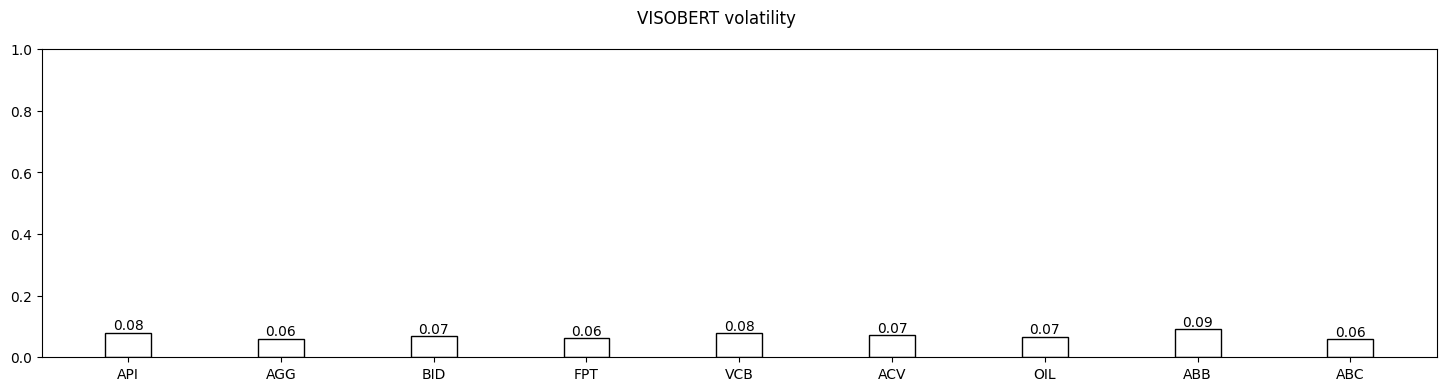

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
volatility_plot = {}

for company, item in company_news.items():
    sentiment_scores = item['sentiment']
    volatility_plot[company] = np.std(sentiment_scores)

for company, volatility in volatility_plot.items():
    plt.text(company_list.index(company), volatility, f"{volatility:.2f}", ha='center', va='bottom')

ax.bar(company_list, volatility_plot.values(), 0.3, color='w', edgecolor='k')
ax.set_ylim(0, 1)

fig.suptitle('VISOBERT volatility')
plt.savefig('visobert_volatility.png')
plt.show()

## Compare 3 models

In [ ]:
sentence = 'tươi'

wonrax_sentiment = {}

input_ids = torch.tensor([wonrax_tokenizer.encode(sentence)])
with torch.no_grad():
  out = wonrax(input_ids)
  wonrax_sentiment['neg'] = round(out.logits.softmax(dim=-1).tolist()[-1][0], 3)
  wonrax_sentiment['pos'] = round(out.logits.softmax(dim=-1).tolist()[-1][1], 3)
  wonrax_sentiment['neu'] = round(out.logits.softmax(dim=-1).tolist()[-1][2], 3)
  wonrax_sentiment['compound'] = round(wonrax_sentiment['pos'] - wonrax_sentiment['neg'], 4)
  print("PHOBERT", wonrax_sentiment)

uit_sentiment = {}
encoding = uit_tokenizer(sentence, return_tensors='pt')
with torch.no_grad():
  output = uit(**encoding)
  uit_sentiment['pos'] = round(output.logits.softmax(dim=-1).tolist()[-1][0], 3)
  uit_sentiment['neg'] = round(output.logits.softmax(dim=-1).tolist()[-1][1], 3)
  uit_sentiment['compound'] = round(uit_sentiment['pos'] - uit_sentiment['neg'], 4)
  print("VISOBERT", uit_sentiment)

print("VADER", analyzer.polarity_scores(sentence))

PHOBERT {'neg': 0.001, 'pos': 0.992, 'neu': 0.007, 'compound': 0.991}
VISOBERT {'pos': 0.537, 'neg': 0.463, 'compound': 0.074}
VADER {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


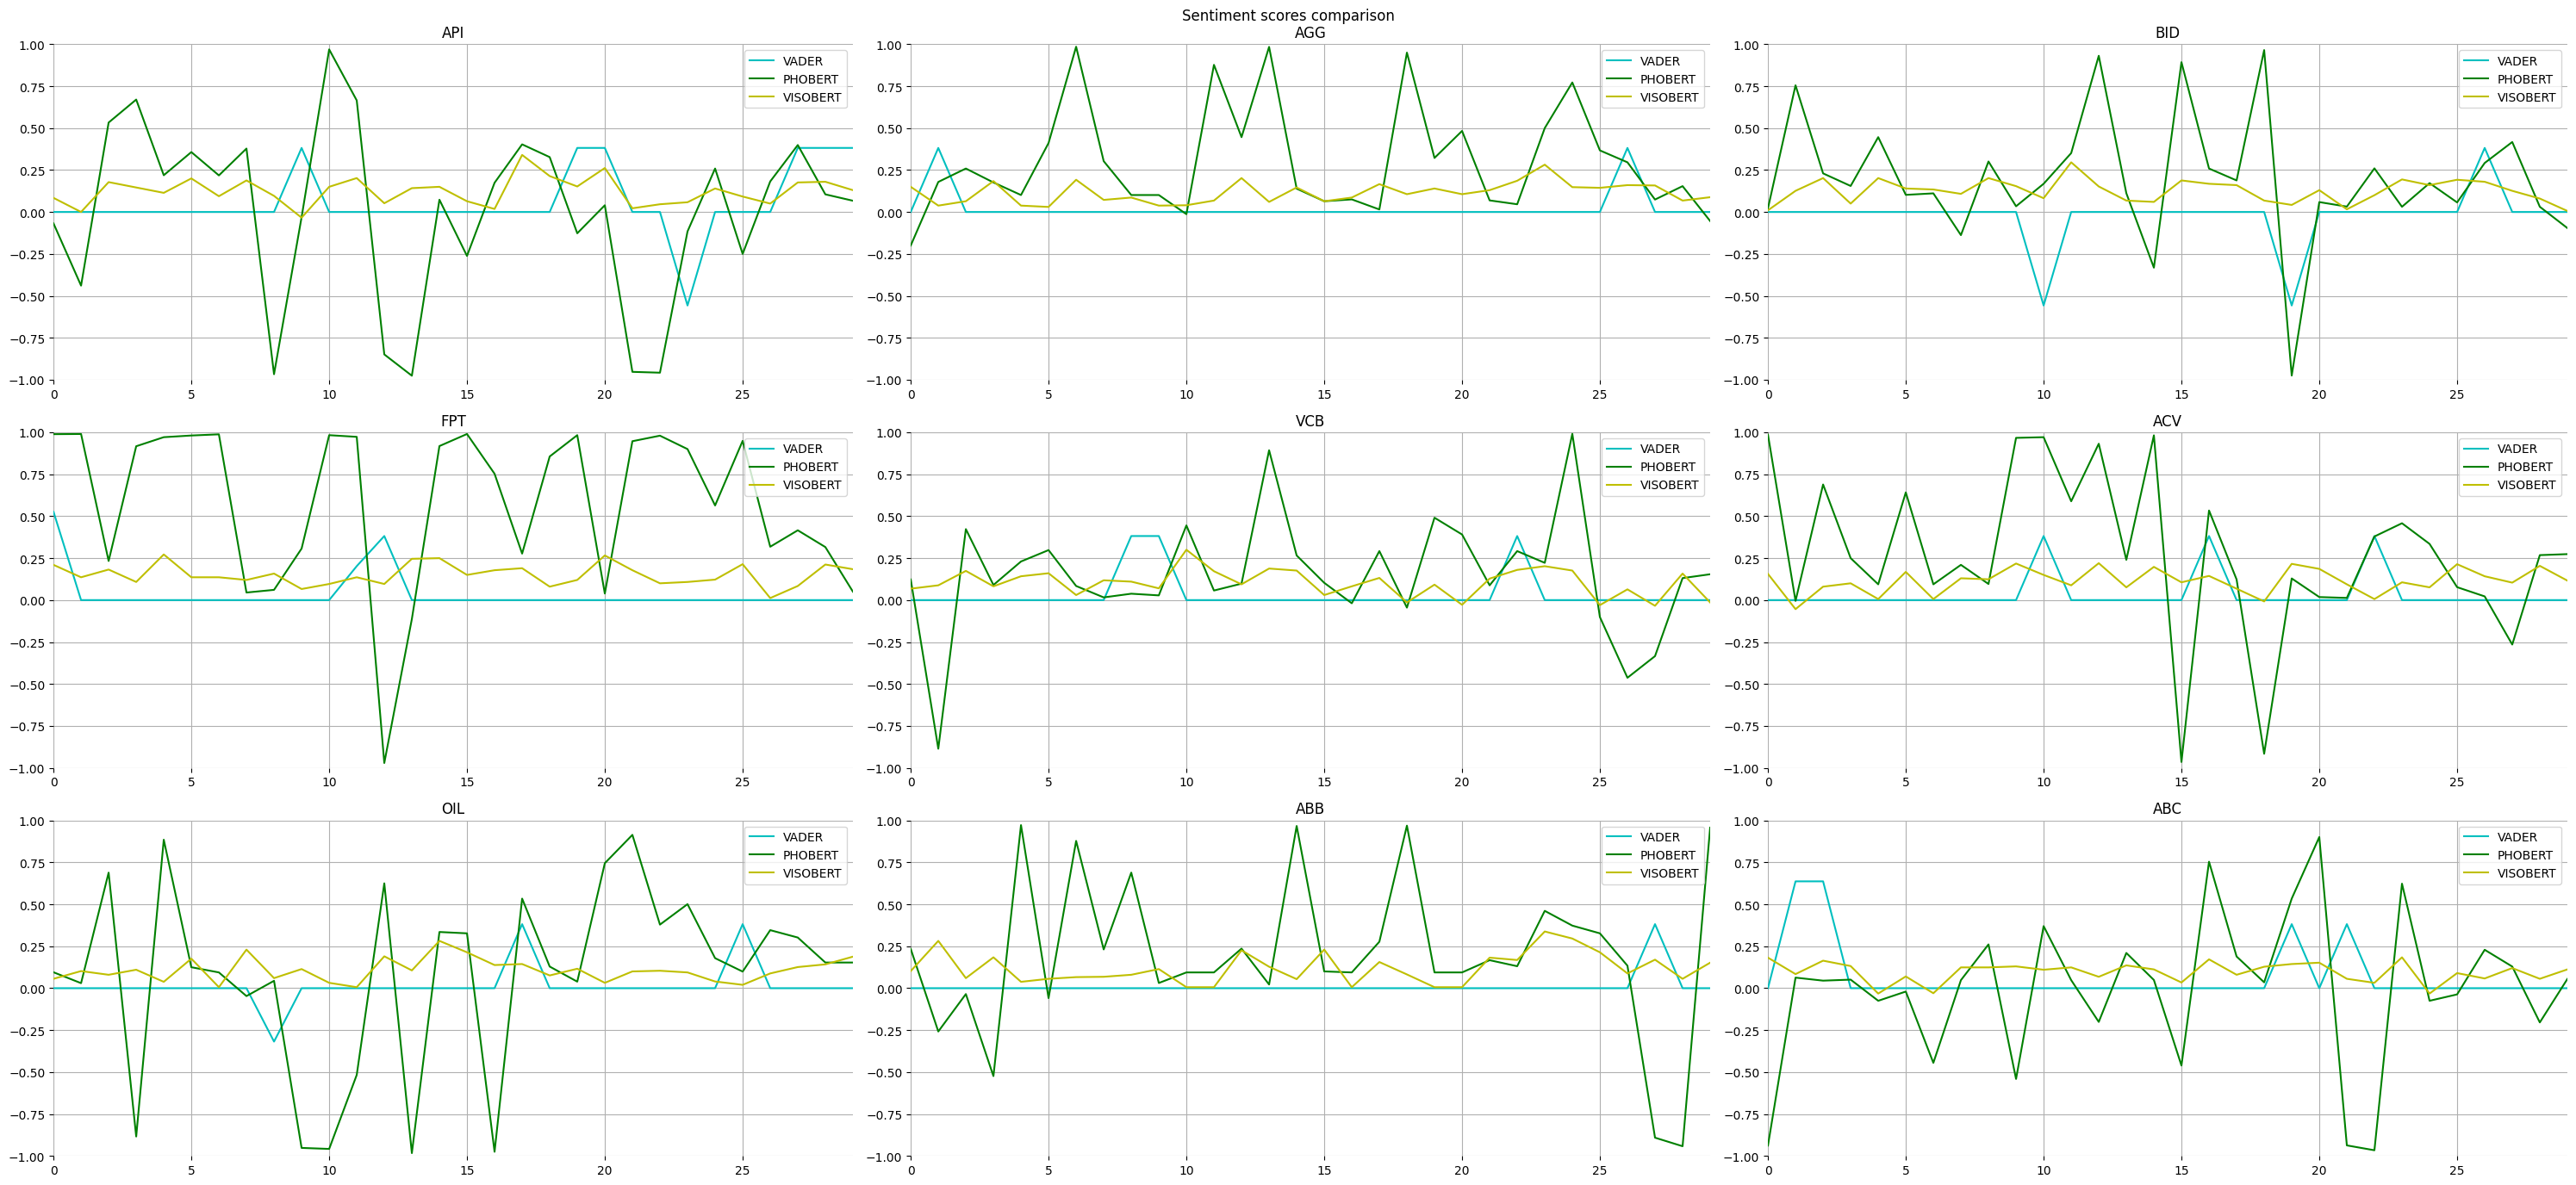

In [ ]:
fig = plt.figure(figsize=(30, 14))

max_length = len(company_news[company_list[0]]['timeline'])

for idx, company in enumerate(company_list):
    plot_index = idx + 1
    plot_col = 3
    plot_row = len(company_list) // plot_col
    ax = fig.add_subplot(plot_row, plot_col, plot_index, frameon=False)
    ax.grid(True)
    ax.set_title(company)
    ax.set_xlim(0, max_length - 1)
    ax.set_ylim(-1, 1)
    ax.plot(vader_sentiment_scores[idx], color='c', label='VADER')
    ax.plot(phobert_sentiment_scores[idx], color='g', label='PHOBERT')
    ax.plot(visobert_sentiment_scores[idx], color='y', label='VISOBERT')
    ax.legend(loc='upper right')

fig.suptitle('Sentiment scores comparison')
plt.legend()
plt.tight_layout()
plt.savefig('compare_sentiment_scores.png')
plt.show()

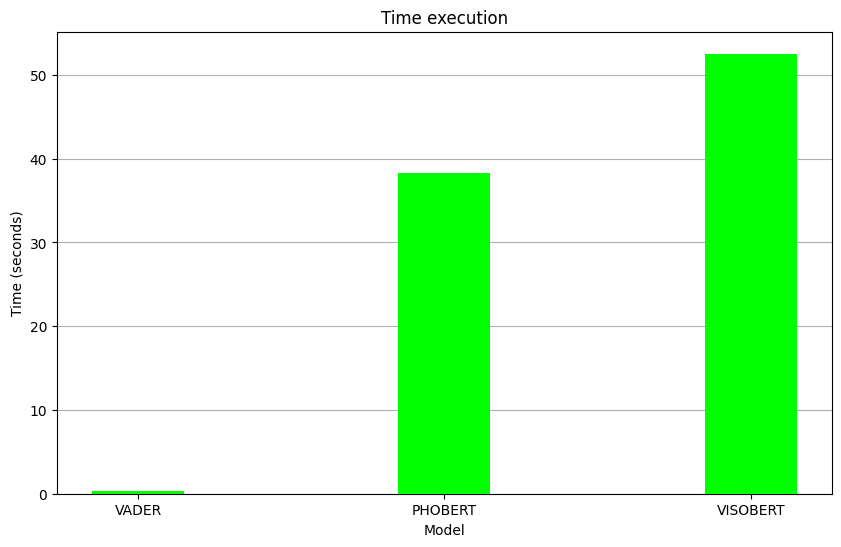

In [ ]:
time_execution = {
    'VADER': vader_time_execution,
    'PHOBERT': phobert_time_execution,
    'VISOBERT': visobert_time_execution
 }

fig, ax = plt.subplots(figsize=(10, 6))
ax.yaxis.grid(zorder=0)
ax.bar(time_execution.keys(), time_execution.values(), color='lime', width=0.3, linewidth=2.5, zorder=3)
ax.set_title('Time execution')
ax.set_xlabel('Model')
ax.set_ylabel('Time (seconds)')
plt.savefig('compare_time_execution.png')
plt.show()

# Download file .png

In [ ]:
from google.colab import files
import os

for filename in os.listdir('/content'):
    if filename.endswith('.png'):
        files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>